In [1]:
import os
import time
import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import scipy 
import seaborn as sns

from collections import Counter
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
#import warnings
#warnings.filterwarnings('ignore')

# metric

In [2]:
def rmse(preds, ys): return ((preds - ys) ** 2).mean() ** 0.5

# Read data

In [87]:
data_path = '../input/commonlitreadabilityprize/'

trn_df = pd.read_csv(data_path + 'train.csv')
test_df = pd.read_csv(data_path + 'test.csv')
sub_df = pd.read_csv(data_path + 'sample_submission.csv')

display(trn_df.sample(5))
display(test_df)
display(sub_df)

,id,url_legal,license,excerpt,target,standard_error
2504,1de294528,NaN,NaN,"Narrower and narrower grew the road, more and ...",-1.796459,0.448439
1698,791a613e9,NaN,NaN,In 1861 I used a horse fork for the first time...,-1.429361,0.485599
279,84101eee4,https://kids.frontiersin.org/article/10.3389/f...,CC BY 4.0,"Brain functions, like perceptions, thoughts, a...",-1.782990,0.472195
682,fe19cd82d,https://kids.frontiersin.org/article/10.3389/f...,CC BY 4.0,Sometimes scientists want to go beyond describ...,-0.460304,0.473691
1067,c2f2356f4,https://www.africanstorybook.org/,CC BY 4.0,"That day, it was about cows at the market. ""Pu...",0.192213,0.494302


,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...
5,12537fe78,NaN,NaN,"To explain transitivity, let us look first at ..."
6,965e592c0,https://www.africanstorybook.org/#,CC BY 4.0,Milka and John are playing in the garden. Her ...


,id,target
0,c0f722661,0.0
1,f0953f0a5,0.0
2,0df072751,0.0
3,04caf4e0c,0.0
4,0e63f8bea,0.0
5,12537fe78,0.0
6,965e592c0,0.0


Columns:
- `id` - unique ID for excerpt
- `url_legal` - URL of source - this is blank in the test set.
- `license` - license of source material - this is blank in the test set.
- `excerpt` - text to predict reading ease of
- `target` - reading ease
- `standard_error` - measure of spread of scores among multiple raters for each excerpt. Not included for test data.

In [4]:
trn_df.nunique()

id                2834
url_legal          667
license             15
excerpt           2834
target            2834
standard_error    2834
dtype: int64

# plot the number of missing values

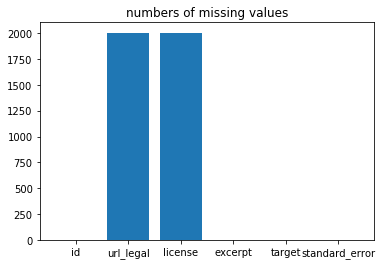

In [5]:
plt.title('numbers of missing values')
plt.bar(trn_df.keys(), trn_df.isna().values.sum(axis=0));

# Show the smallest and the largest taget value of excerpts. 
The smaller target values are hard to read and the larger taget values are easy to read.


The excerpt which id is  436ce79fe is set as baseline for comparisons.

In [6]:
baseline_excerpt = trn_df.query('target == 0')
print(f'baseline excerpt, id:, ', baseline_excerpt.id.values[0])
print('-' * 30)
print(baseline_excerpt.excerpt.values[0])
display(baseline_excerpt)

excerpt = trn_df.query(f'target == {trn_df.target.min()}')
print(f'\nhardest excerpt, id:, ', excerpt.id.values[0])
print('-' * 30)
print(excerpt.excerpt.values[0])
display(trn_df.sort_values('target').head())


excerpt = trn_df.query(f'target == {trn_df.target.max()}')
print(f'\neasiest excerpt, id:, ', excerpt.id.values[0])
print('-' * 30)
print(excerpt.excerpt.values[0])
display(trn_df.sort_values('target', ascending=False).head())

baseline excerpt, id:,  436ce79fe
------------------------------
The sun was shining in a cloudless sky, and no shadows lay on the mountain, and all day long they watched and waited, and at last, when the birds were singing their farewell song to the evening star, the children saw the shadows marching from the glen, trooping up the mountain side and dimming the purple of the heather.
And when the mountain top gleamed like a golden spear, they fixed their eyes on the line between the shadow and the sunshine.
"Now," said Connla, "the time has come."
"Oh, look! look!" said Nora, and as she spoke, just above the line of shadow a door opened out, and through its portals came a little piper dressed in green and gold. He stepped down, followed by another and another, until they were nine in all, and then the door slung back again.


,id,url_legal,license,excerpt,target,standard_error
106,436ce79fe,NaN,NaN,"The sun was shining in a cloudless sky, and no...",0.0,0.0



hardest excerpt, id:,  4626100d8
------------------------------
The commutator is peculiar, consisting of only three segments of a copper ring, while in the simplest of other continuous current generators several times that number exist, and frequently 120! segments are to be found. These three segments are made so as to be removable in a moment for cleaning or replacement. They are mounted upon a metal support, and are surrounded on all sides by a free air space, and cannot, therefore, lose their insulated condition. This feature of air insulation is peculiar to this system, and is very important as a factor in the durability of the commutator. Besides this, the commutator is sustained by supports carried in flanges upon the shaft, which flanges, as an additional safeguard, are coated all over with hard rubber, one of the finest known insulators. It may be stated, without fear of contradiction, that no other commutator made is so thoroughly insulated and protected. The three commutat

,id,url_legal,license,excerpt,target,standard_error
1705,4626100d8,NaN,NaN,"The commutator is peculiar, consisting of only...",-3.676268,0.623621
1128,493b80aa7,NaN,NaN,The Dunwich horror itself came between Lammas ...,-3.668360,0.571404
1754,fe44cbd14,NaN,NaN,"The iron cylinder weighs 23 kilogrammes; but, ...",-3.642892,0.644398
1752,284eaa5ad,NaN,NaN,As to surface-slope its measurement—from nearl...,-3.639936,0.603819
1720,9e9eacb49,NaN,NaN,"The tree is dioecious, bearing male catkins on...",-3.636834,0.606822



easiest excerpt, id:,  25ca8f498
------------------------------
When you think of dinosaurs and where they lived, what do you picture? Do you see hot, steamy swamps, thick jungles, or sunny plains? Dinosaurs lived in those places, yes. But did you know that some dinosaurs lived in the cold and the darkness near the North and South Poles?
This surprised scientists, too. Paleontologists used to believe that dinosaurs lived only in the warmest parts of the world. They thought that dinosaurs could only have lived in places where turtles, crocodiles, and snakes live today. Later, these dinosaur scientists began finding bones in surprising places.
One of those surprising fossil beds is a place called Dinosaur Cove, Australia. One hundred million years ago, Australia was connected to Antarctica. Both continents were located near the South Pole. Today, paleontologists dig dinosaur fossils out of the ground. They think about what those ancient bones must mean.


,id,url_legal,license,excerpt,target,standard_error
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
981,849971671,https://www.africanstorybook.org/,CC BY 4.0,"For her last birthday, Sisanda had a special t...",1.597870,0.596349
808,8f35441e3,https://www.africanstorybook.org/#,CC BY 4.0,"Every day, Emeka's father took him to school i...",1.583847,0.624776
1014,7a1d484be,https://www.africanstorybook.org/,CC BY 4.0,More people came to the bus stop just before 9...,1.541672,0.606997
1066,016913371,https://www.africanstorybook.org/,CC BY 4.0,Grandma's garden was wonderful. It was full of...,1.467665,0.599600


# only one standard error (baseline excerpt) smaller than 0.4

In [7]:
print('standard_error values < 0.4:',
      len(trn_df.query("standard_error < 0.4")))

standard_error values < 0.4: 1


# Plot the distribution and show quantile of target and standard_error

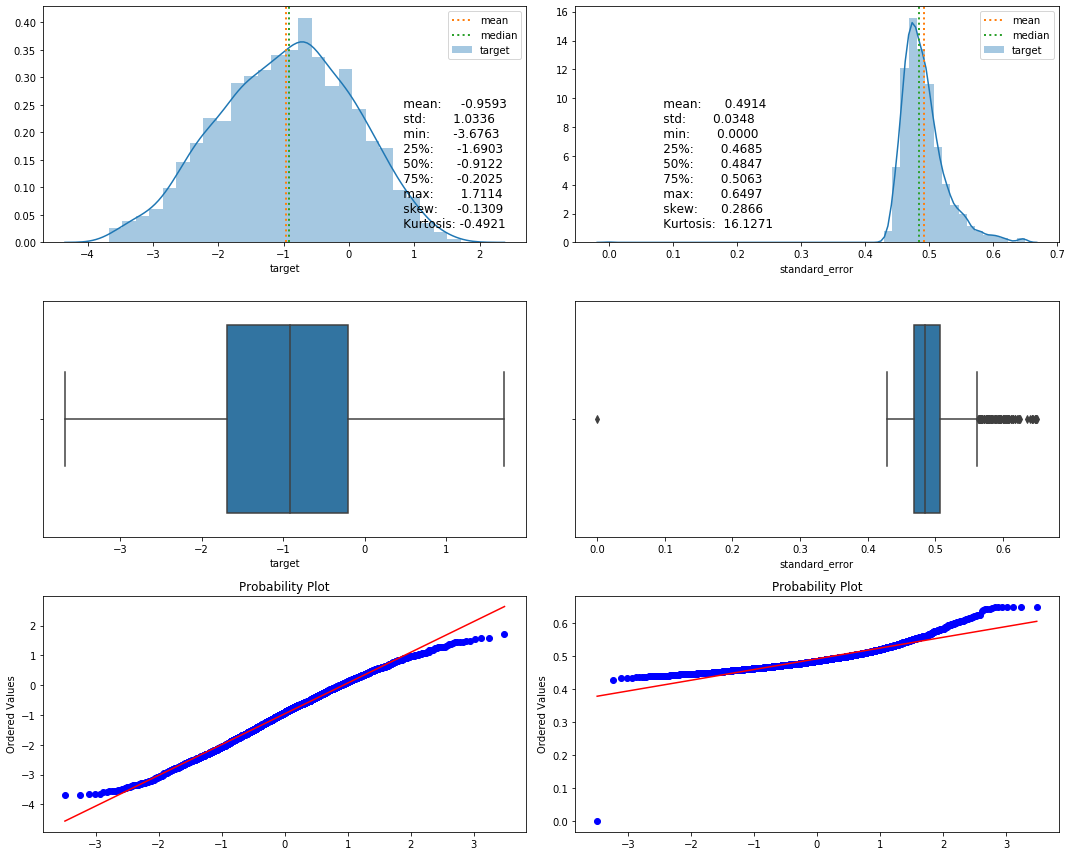

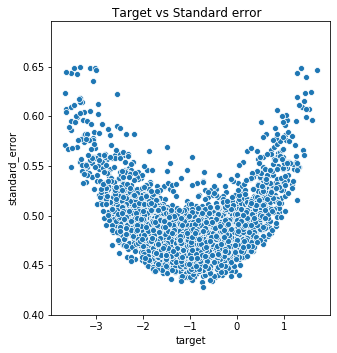

In [8]:
# dist
fig, ax = plt.subplots(3, 2, figsize=(15, 12))
targets = ['target', 'standard_error']

for i, target in enumerate(targets):
    sns.distplot(trn_df[target], ax=ax[0, i], label='target')
    ax[0, i].axvline(trn_df[target].mean(), lw=2, ls=':', c='C1', label='mean')
    ax[0, i].axvline(trn_df[target].median(),
                     lw=2,
                     ls=':',
                     c='C2',
                     label='median')
    ax[0, i].legend()

    texts = f'\n\
              mean:     {trn_df[target].mean(): .4f}\n\
              std:      {trn_df[target].std(): .4f}\n\
              min:      {trn_df[target].min(): .4f}\n\
              25%:      {trn_df[target].quantile(0.25): .4f}\n\
              50%:      {trn_df[target].quantile(0.50): .4f}\n\
              75%:      {trn_df[target].quantile(0.75): .4f}\n\
              max:      {trn_df[target].max(): .4f}\n\
              skew:     {trn_df[target].skew(): .4f}\n\
              Kurtosis: {trn_df[target].kurtosis(): .4f}\n'

    ax[0, i].text(0, 0, texts, size=12)

    sns.boxplot(x=target, data=trn_df, ax=ax[1, i])

    scipy.stats.probplot(trn_df[target], plot=ax[2, i])
    ax[2, i].set_xlabel('')

plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
sns.scatterplot(*targets, data=trn_df)
plt.ylim([0.4, None])
plt.suptitle("Target vs Standard error")
plt.subplots_adjust(top=0.94)
plt.show()

Discrete the target intervals, to conveniently use the stratified or grouped KFolds.

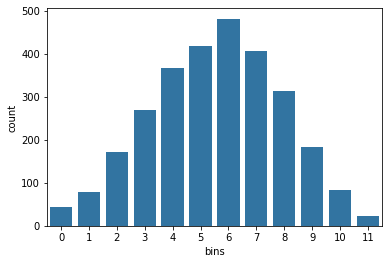

In [9]:
# calculate number of bins by Sturge's rule
bins = round(1 + np.log2(len(trn_df)))
#trn_df.sample(frac=1).reset_index(drop=True)
trn_df['bins'] = pd.cut(trn_df.target, bins, labels=False)

sns.countplot(trn_df['bins'], color='C0')

# Plot the number of licenses

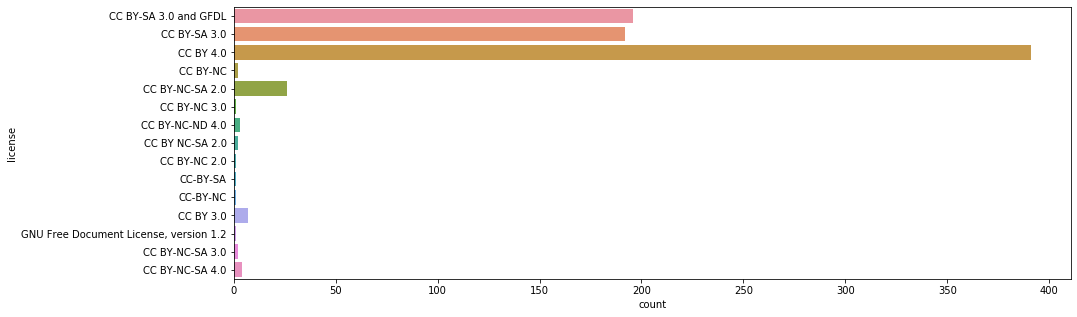

In [10]:
plt.figure(figsize=(15, 5))
sns.countplot(y='license', data=trn_df);

# Plot the number of website urls

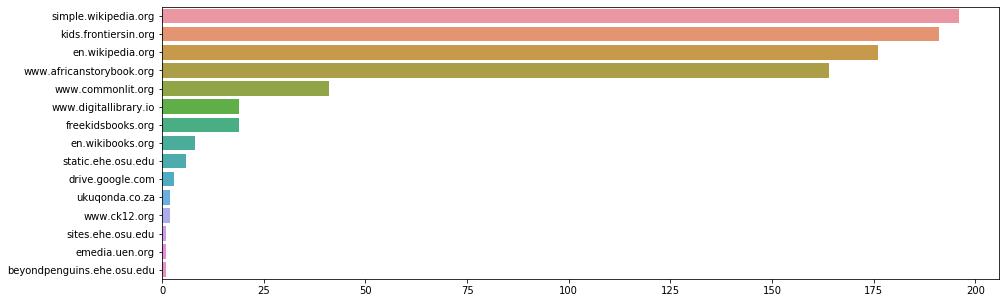

In [11]:
plt.figure(figsize=(15, 5))
website = trn_df[trn_df.url_legal.notna()].url_legal.apply(lambda x: x.split('/')[2])
sns.barplot(data=pd.DataFrame(website.value_counts()).T, orient='h');

# Plot some excerpt features

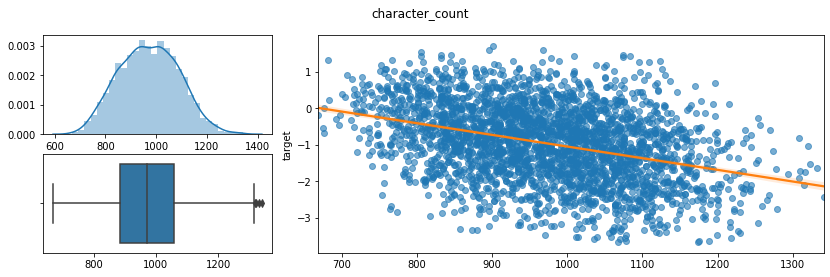

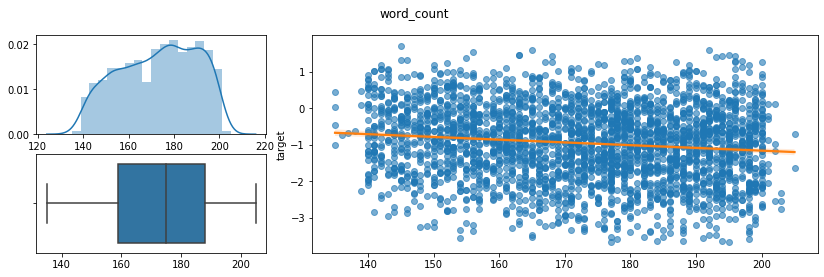

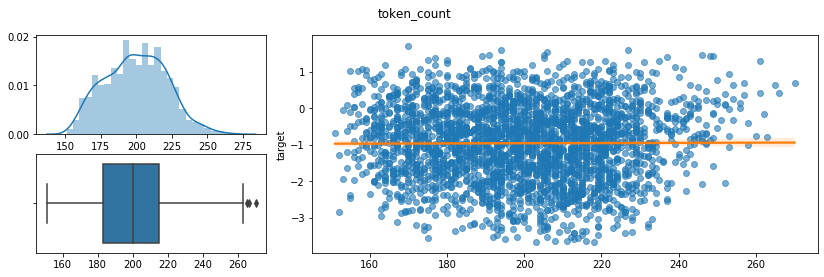

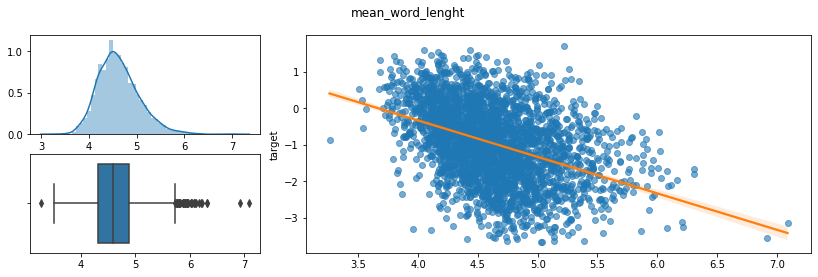

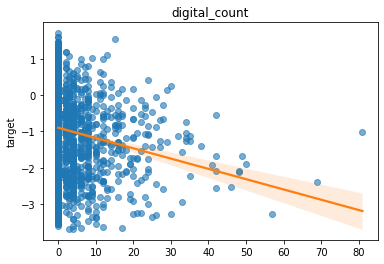

In [12]:
trn_df['character_count'] = trn_df.excerpt.apply(lambda x: len(x))
trn_df['word_count'] = trn_df.excerpt.str.split().apply(lambda x: len(x))
trn_df['token_count'] =trn_df.excerpt.apply(lambda x: len(word_tokenize(x)))
trn_df['mean_word_lenght'] = trn_df.excerpt.str.split().apply(lambda x: np.mean([len(i) for i in x]))
trn_df['digital_count'] = trn_df.excerpt.apply(lambda x: sum(c.isdigit() for c in x))

features = ['character_count', 'word_count', 'token_count', 'mean_word_lenght']

for feature in features:
    plt.figure(figsize=(14, 4))
    plt.suptitle(feature)
    plt.subplot(2, 3, 1)
    sns.distplot(trn_df[feature])
    plt.subplot(2, 3, 4)
    sns.boxplot(trn_df[feature])
    plt.xlabel('')
    plt.subplot2grid((2, 3), (0, 1), rowspan=2, colspan=3)
    sns.regplot(feature,
                'target',
                trn_df,
                scatter_kws={'alpha': 0.6},
                line_kws={'color': 'C1'})
    plt.xlabel('')
    plt.show()

plt.title('digital_count')
sns.regplot('digital_count',
            'target',
            trn_df,
            scatter_kws={'alpha': 0.6},
            line_kws={'color': 'C1'})
plt.xlabel('')
plt.show()

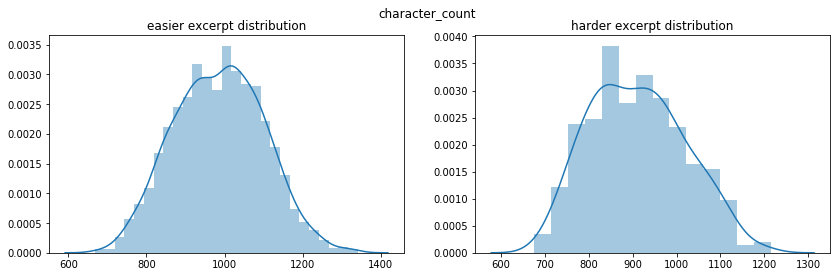

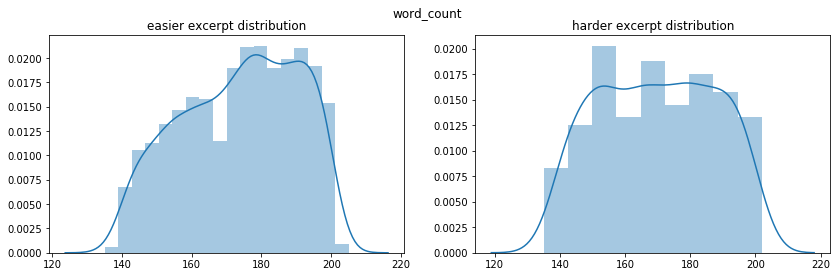

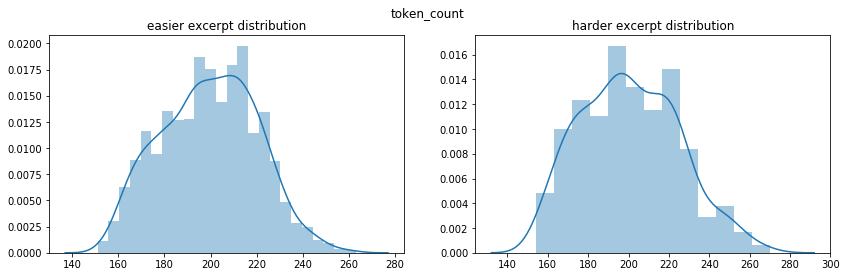

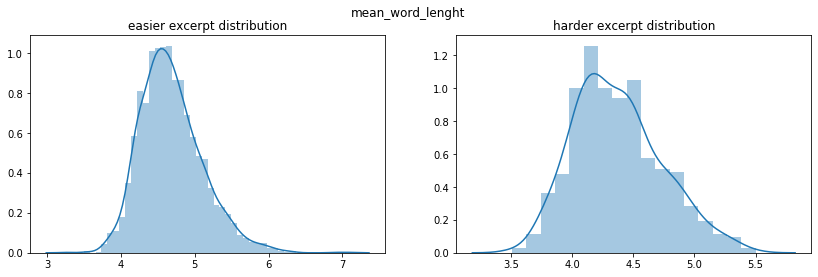

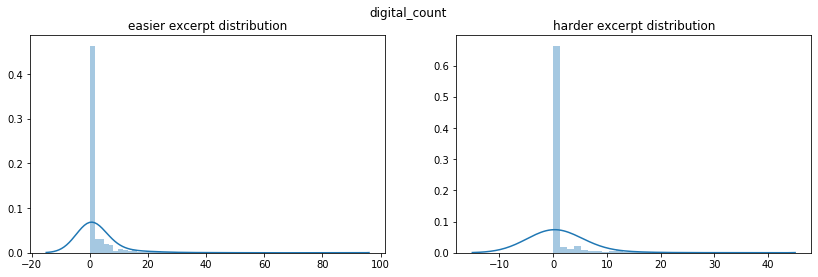

In [13]:
features = [
    'character_count', 
    'word_count', 
    'token_count', 
    'mean_word_lenght',
    'digital_count'
]

for feature in features:
    plt.figure(figsize=(14, 4))
    plt.suptitle(feature)
    plt.subplot(1, 2, 1)
    plt.title('easier excerpt distribution')
    kde_kws = {'bw': 5.} if feature == 'digital_count' else None
    sns.distplot(trn_df.query('target < 0')[feature], kde_kws=kde_kws)
    plt.xlabel('')
    plt.subplot(1, 2, 2)
    plt.title('harder excerpt distribution')
    sns.distplot(trn_df.query('target > 0')[feature], kde_kws=kde_kws)
    plt.xlabel('')
    plt.show()

# Plot wordcloud

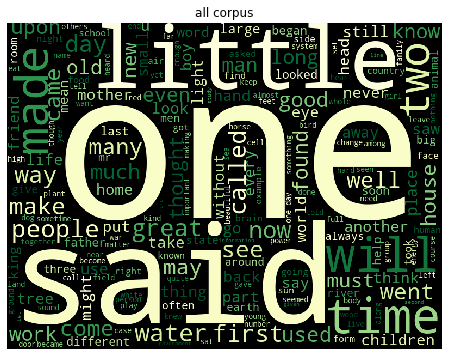

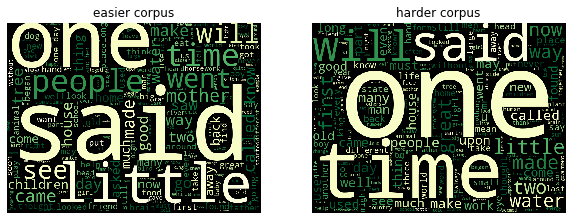

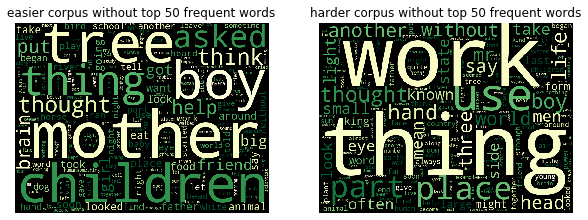

In [14]:
# wc
def create_corpus(df, with_stopwords=False):
    stopwords = [] if with_stopwords else STOPWORDS
    return [
        re.sub(r'[/.,?;"()\']', '', w.lower())
        for row in df.excerpt.str.split() for w in row
        if w.lower() not in stopwords
    ]


def plot_wordcloud(texts, title=''):
    wc = WordCloud(width=800, height=600, random_state=42,
                   colormap="YlGn").generate(texts)
    plt.title(title)
    plt.imshow(wc)
    plt.axis('off')

# create corpus
corpus = create_corpus(trn_df)
most_words, most_count = list(zip(*[i for i in nltk.FreqDist(corpus).most_common(50)]))
corpus_easier = create_corpus(trn_df.query('target > 0'))
corpus_harder = create_corpus(trn_df.query('target < 0'))

# fig1
plt.figure(figsize=(12, 6))
texts = ' '.join(token for token in corpus)
plot_wordcloud(texts, title='all corpus')

# fig2
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
texts = ' '.join(token for token in corpus_easier)
plot_wordcloud(texts, title='easier corpus')
plt.subplot(1, 2, 2)
texts = ' '.join(token for token in corpus_harder)
plot_wordcloud(texts, title='harder corpus')

# fig3
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
texts = ' '.join(token for token in corpus_easier if token not in most_words)
plot_wordcloud(texts, title='easier corpus without top 50 frequent words')
plt.subplot(1, 2, 2)
texts = ' '.join(token for token in corpus_harder if token not in most_words)
plot_wordcloud(texts, title='harder corpus without top 50 frequent words')

# Plot n_grams

In [15]:
def create_n_grams(corpus, n_grams=1): 
    return [*zip(*[corpus[i:] for i in range(n_grams)])]

def plot_top_ngrams(corpus, n_grams=1, top_feqs=20, color='C1'):
    ngrams = create_n_grams(corpus, n_grams)
    
    counter = Counter(ngrams)
    most_words, most_counts = [*zip(*counter.most_common(top_feqs))]
    most_words = [' '.join(w) for w in most_words]
    
    sns.barplot(x=most_counts, y=most_words, color=color)

unigrams


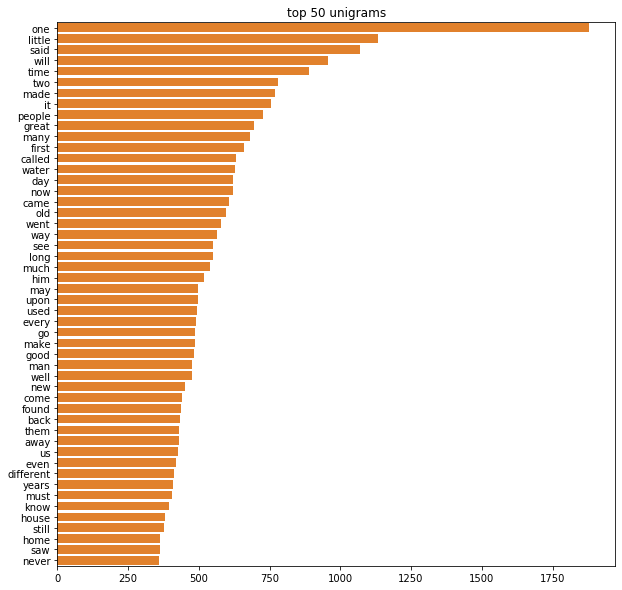

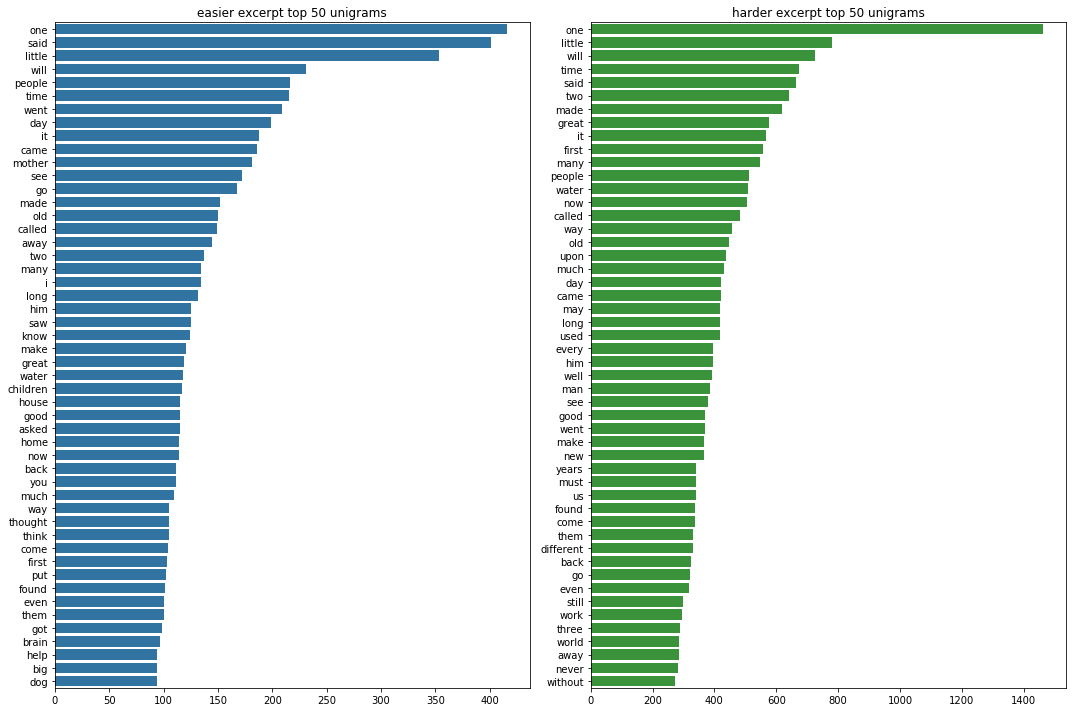

Bigrams


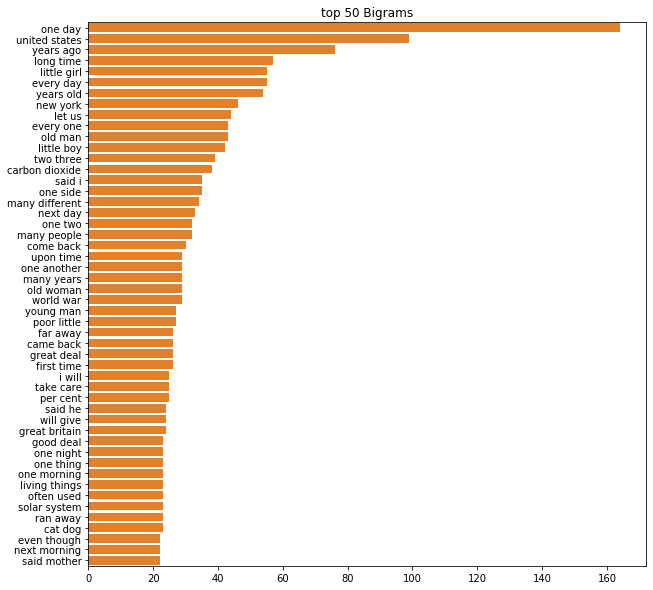

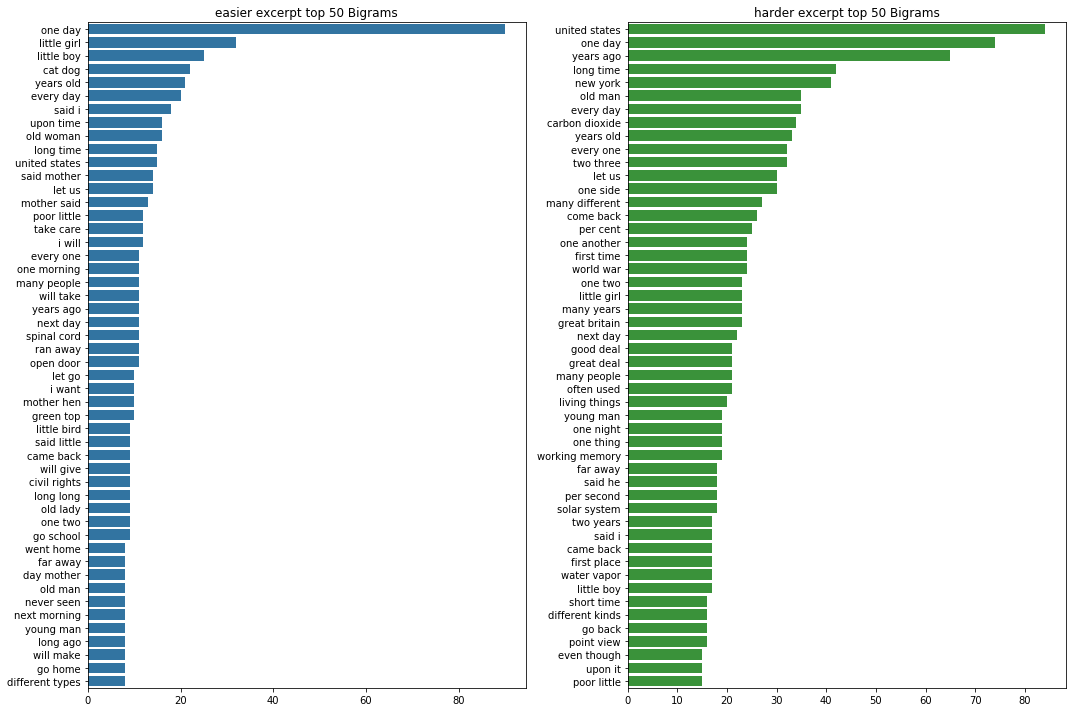

Trigrams


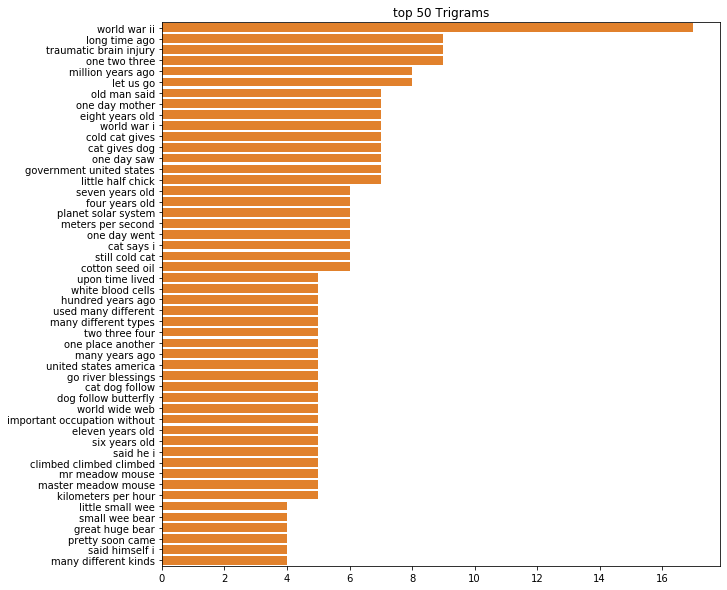

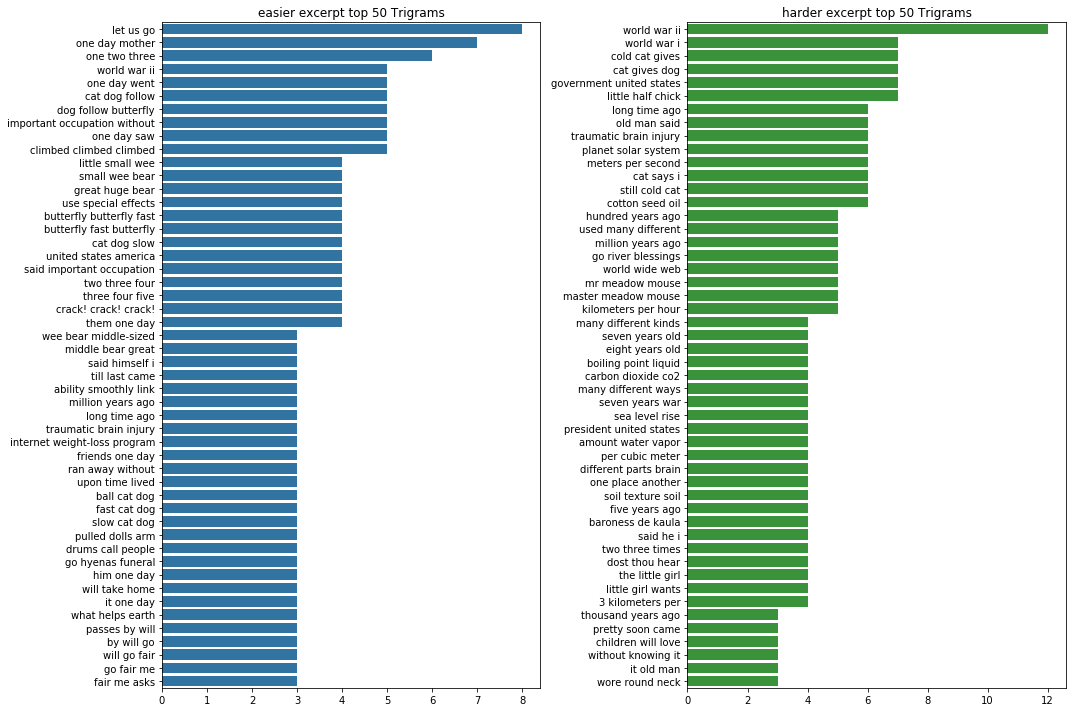

In [16]:
top_feqs = 50

titles = ['unigrams', 'Bigrams', 'Trigrams']

for n_grams, title in enumerate(titles, 1):
    print(title)
    plt.figure(figsize=(10, 10))
    plt.title(f'top {top_feqs} {title}')
    plot_top_ngrams(corpus, n_grams=n_grams, top_feqs=top_feqs, color='C1')
    plt.show()

    plt.figure(figsize=(15, 10))
    plt.subplot(121)
    plt.title(f'easier excerpt top {top_feqs} {title}')
    plot_top_ngrams(corpus_easier, n_grams=n_grams, top_feqs=top_feqs, color='C0')
    plt.subplot(122)
    plt.title(f'harder excerpt top {top_feqs} {title}')
    plot_top_ngrams(corpus_harder, n_grams=n_grams, top_feqs=top_feqs, color='C2')
    plt.tight_layout()
    plt.show()

## n_grams with stop word

unigrams


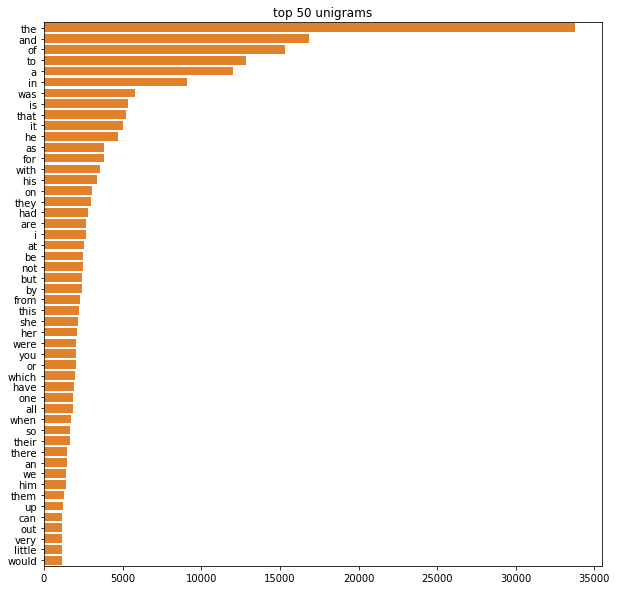

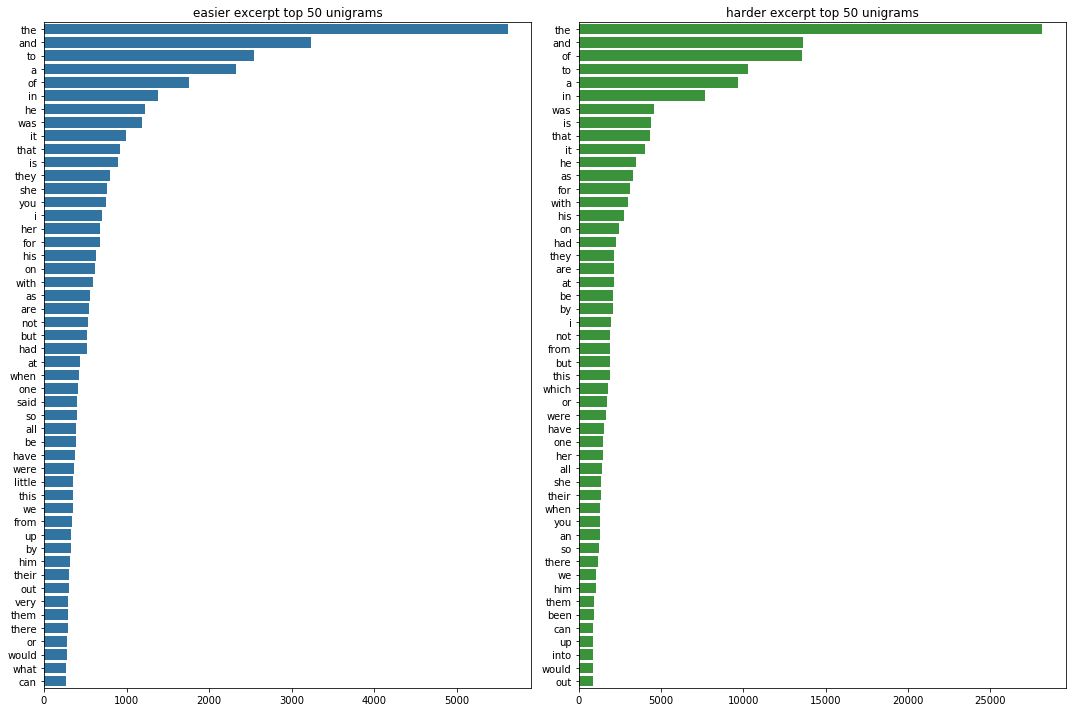

Bigrams


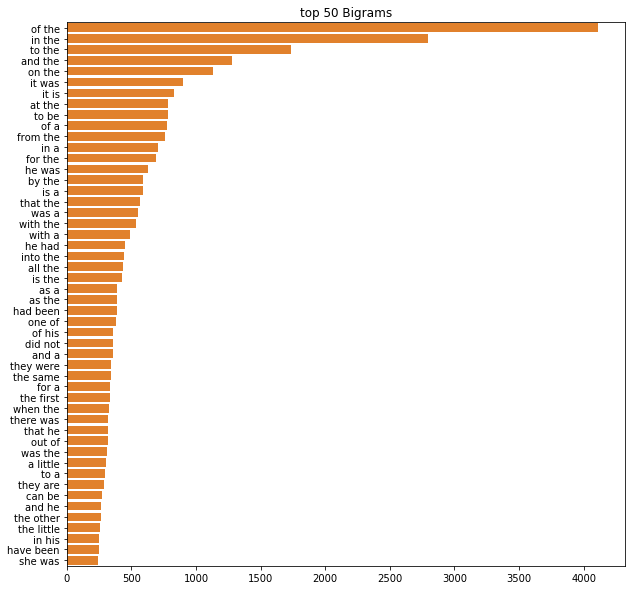

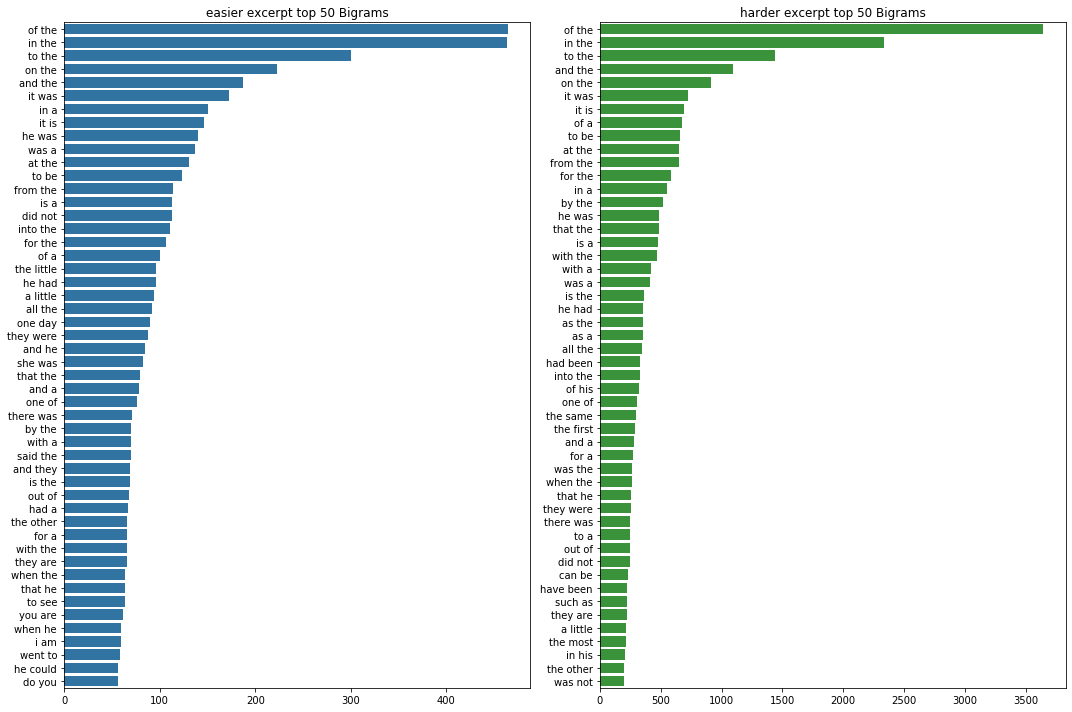

Trigrams


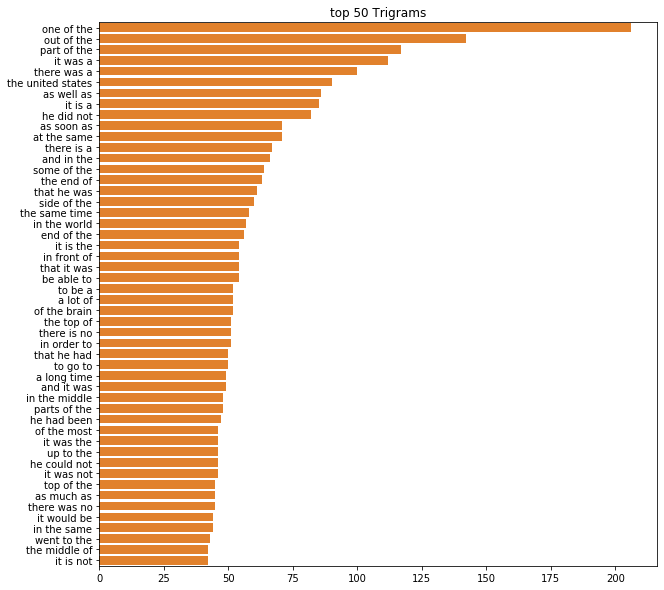

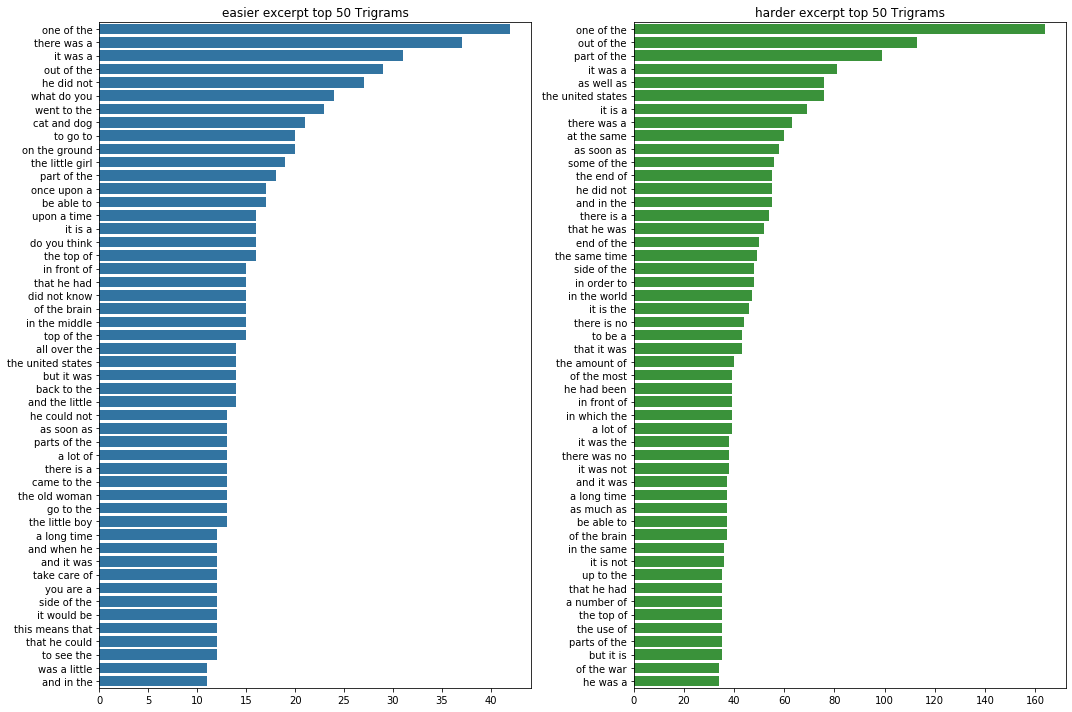

In [17]:
# create corpus
corpus = create_corpus(trn_df, with_stopwords=True)
most_words, most_count = list(zip(*[i for i in nltk.FreqDist(corpus).most_common(50)]))
corpus_easier = create_corpus(trn_df.query('target > 0'), with_stopwords=True)
corpus_harder = create_corpus(trn_df.query('target < 0'), with_stopwords=True)


titles = ['unigrams', 'Bigrams', 'Trigrams']

for n_grams, title in enumerate(titles, 1):
    print(title)
    plt.figure(figsize=(10, 10))
    plt.title(f'top {top_feqs} {title}')
    plot_top_ngrams(corpus, n_grams=n_grams, top_feqs=top_feqs, color='C1')
    plt.show()

    plt.figure(figsize=(15, 10))
    plt.subplot(121)
    plt.title(f'easier excerpt top {top_feqs} {title}')
    plot_top_ngrams(corpus_easier, n_grams=n_grams, top_feqs=top_feqs, color='C0')
    plt.subplot(122)
    plt.title(f'harder excerpt top {top_feqs} {title}')
    plot_top_ngrams(corpus_harder, n_grams=n_grams, top_feqs=top_feqs, color='C2')
    plt.tight_layout()
    plt.show()

# POS_tag

|  Abbreviation  | Meaning  |
|  ----  | ----  |
|CC|	Coordinating conjunction|
|CD|	Cardinal number|
|DT|	Determiner|
|EX|	Existential there|
|FW|	Foreign word|
|IN|	Preposition or subordinating conjunction|
|JJ|	Adjective|
|JJR|	Adjective, comparative|
|JJS|	Adjective, superlative|
|LS	|List item marker|
|MD|	Modal|
|NN|	Noun, singular or mass|
|NNS|	Noun, plural|
|NNP|	Proper noun, singular|
|NNPS|	Proper noun, plural|
|PDT|	Predeterminer|
|POS|	Possessive ending|
|PRP|	Personal pronoun|
|PRP\$|	Possessive pronoun|
|RB|	Adverb|
|RBR|	Adverb, comparative|
|RBS|	Adverb, superlative|
|RP|	Particle|
|SYM|	Symbol|
|TO|	to|
|UH|	Interjection|
|VB|	Verb, base form|
|VBD|	Verb, past tense|
|VBG|	Verb, gerund or present participle|
|VBN|	Verb, past participle|
|VBP|	Verb, non-3rd person singular present|
|VBZ|	Verb, 3rd person singular present|
|WDT|	Wh-determiner|
|WP|	Wh-pronoun|
|WP\$|	Possessive wh-pronoun|
|WRB|	Wh-adverb|

In [18]:
trn_df['pos_tags'] = trn_df.excerpt.str.split().apply(nltk.pos_tag).apply(lambda x: [*zip(*x)][1])

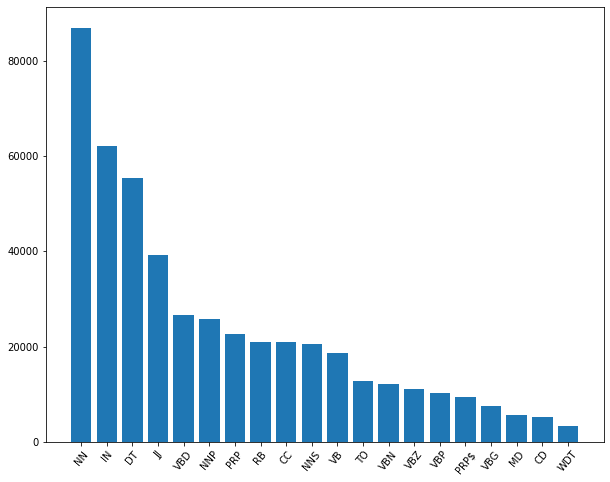

In [19]:
postags = [postag for row in trn_df['pos_tags'] for postag in row]
counter = Counter(postags)
plt.figure(figsize=(10, 8))
plt.bar(*[*zip(*counter.most_common(20))])
plt.xticks(rotation=50)
plt.show()

# Some bert usage brief

In [64]:
import torch
import torch.nn as nn
import transformers

from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import RobertaTokenizer, BertTokenizer

from torch.utils.data import DataLoader, Dataset

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## tokenization

Maximum input length is **512** in Bert pretrained models, because self-attention in transformer has $O(n^2)$ compexity.  

In [21]:
text = trn_df.excerpt[0]
print('Before encoded:')
print('-' * 30)
print(text)


print('\nAfer encoded:')
print('-' * 30)
result = tokenizer.encode_plus(text)
print('input_ids:\n', result['input_ids'])
print('attention_mask:\n', result['attention_mask'])

print('\nAfer decoded:')
print('-' * 30)
print(tokenizer.decode(result['input_ids']))

Before encoded:
------------------------------
When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.
The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.
At each end of the room, on the wall, hung a beautiful bear-skin rug.
These rugs were for prizes, one for the girls and one for the boys. And this was the game.
The girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.
This would have been an easy matter, but each t

You can see that **<s\>** have been added in the begin  abd **<\/s>** have been added in the end. These two are called Special tokens. Those would be different if using different tokenizer(model).

For example, we changed into the bert tokenizer:

In [22]:
print('Before encoded:')
print('-' * 30)
print(text)

print('Afer encoded:')
print('-' * 30)
result = bert_tokenizer.encode(text)
print('input_ids:\n', result)

print('\nAfer decoded:')
print('-' * 30)
print(bert_tokenizer.decode(result))

print('\nUsing incorrect decoder:')
print('-' * 30)
print(tokenizer.decode(result))

Before encoded:
------------------------------
When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.
The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.
At each end of the room, on the wall, hung a beautiful bear-skin rug.
These rugs were for prizes, one for the girls and one for the boys. And this was the game.
The girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.
This would have been an easy matter, but each t

You can see that **<s\>** and **<\/s>** are changed into **[CLS]** and **[SEP]**, if we use the vanilla bert instead of the roberta. The ids are different also, so if you use the incorrect decoder, the result would be garbled.

It is necessary to let the number of words in each sentence `equal` in Bert.

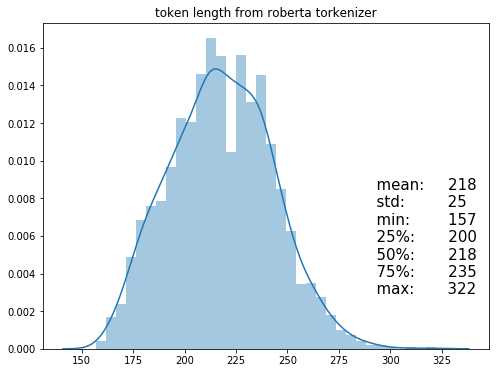

In [23]:
trn_df['tokenized'] = trn_df.excerpt.apply(lambda x: tokenizer.encode_plus(x)["input_ids"])
trn_df['token_lens'] = trn_df['tokenized'].apply(len)

plt.figure(figsize=(8, 6))
plt.title('token length from roberta torkenizer')
texts = f'\n\
          mean:    {trn_df["token_lens"].mean(): .0f}\n\
          std:        {trn_df["token_lens"].std(): .0f}\n\
          min:       {trn_df["token_lens"].min(): .0f}\n\
          25%:      {trn_df["token_lens"].quantile(0.25): .0f}\n\
          50%:      {trn_df["token_lens"].quantile(0.50): .0f}\n\
          75%:      {trn_df["token_lens"].quantile(0.75): .0f}\n\
          max:      {trn_df["token_lens"].max(): .0f}\n'

sns.distplot(trn_df['token_lens'], color='C0')
plt.text(270, 0.002, texts, size=15)
plt.xlabel('')
plt.show()

The maximum number of tokens (include <s\>, <\/s>) is `322`.

In [24]:
print('original text:', f'length = {len(text.split(" "))}')
print('-' * 30)
print(text)


print('\nAfer encoded:')
print('-' * 30)
result = tokenizer.encode_plus(
    text,
    add_special_tokens=True, # <s> and </s>
    max_length=322,          # default 512 for bert
    padding='max_length',    # padding  <pad>
    truncation=True,         # cut if length > max length
)
print('input_ids:\n', result['input_ids'])
print('attention_mask:\n', result['attention_mask'])


print('\nAfer decoded:', f'length = {len(result["input_ids"])}')
print('-' * 30)
print(tokenizer.decode(result['input_ids']))

original text: length = 174
------------------------------
When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.
The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.
At each end of the room, on the wall, hung a beautiful bear-skin rug.
These rugs were for prizes, one for the girls and one for the boys. And this was the game.
The girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.
This would have been an easy matter

It can be seen that <pad\> has been added to make the length of the sentences uniform.  
0 in Attention mask means to hide it and ignore it.

In [25]:
q95 = trn_df["token_lens"].quantile(0.95)
print(f'95% token_length are shorter than {q95:.0f}')

95% token_length are shorter than 259


In this case, 95% of the token lengths are shorter than 256, but max length is 322.  
If the length is too long, you can set the `max_length` youself.  It can save a lot of calculation time.

Here is an example:

In [26]:
print('original text:', f'length = {len(text.split(" "))}')
print('-' * 30)
print(text)


print('\nAfer encoded:')
print('-' * 30)
result = tokenizer.encode_plus(
    text,
    add_special_tokens=True, # <s> and </s>
    max_length=15,          # default 512 for bert
    padding='max_length',    # padding  <pad>
    truncation=True,         # cut if length > max length
)
print('input_ids:\n', result['input_ids'])
print('attention_mask:\n', result['attention_mask'])


print('\nAfer decoded:', f'length = {len(result["input_ids"])}')
print('-' * 30)
print(tokenizer.decode(result['input_ids']))

original text: length = 174
------------------------------
When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.
The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.
At each end of the room, on the wall, hung a beautiful bear-skin rug.
These rugs were for prizes, one for the girls and one for the boys. And this was the game.
The girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.
This would have been an easy matter

Here are some roberta pretrained models depending on the application: 

    'RobertaModel',  
    'RobertaForCausalLM',  
    'RobertaForCausalLM',  
    'RobertaForMaskedLM',  
    'RobertaForMultipleChoice',  
    'RobertaForQuestionAnswering',  
    'RobertaForSequenceClassification',  
    'RobertaForTokenClassification',  

## model

The model is too large to run on my gpu, so in this example, just using cpu.

In [54]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [55]:
class BERTDataSet(Dataset):
    def __init__(self, df, tokenizer):
        self.sentences = df.excerpt
        self.targets = df.target
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):

        sentence = self.sentences[idx]

        encoded = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # <s> and </s>
            max_length=322,          # default 512 for bert
            padding='max_length',    # padding  <pad>
            truncation=True,         # cut if length > max length
        )

        ids = torch.tensor(encoded['input_ids'], dtype=torch.long)
        mask = torch.tensor(encoded['attention_mask'], dtype=torch.long)

        target = torch.tensor(self.targets[idx], dtype=torch.float)

        return {
            'ids': ids,
            'masks': mask,
            'targets': target
        }

dataset debug

In [68]:
trn_ds = BERTDataSet(trn_df, tokenizer)
trn_ds[0]

{'ids': tensor([    0,  1779,     5,   664,    82,  1835,     7,     5,  1011,  4294,
             6,    24,  2633,    10, 27265,  1714,  2772,     4,  2978,     9,
            41,  6291,  1310,     6,    24,    21,    10,  2608,  5252,     4,
         50118,   133,  1929,    21,  2913,    19,  1958,    12,  9830, 20790,
             6,    45,  4976,    15, 17359,     6,    53, 11122, 18331,    81,
         24271,     8,  9910,  6368,     6,   101,    10,   588,  1958,   882,
             4,    20,  3617, 38325,     8,   655,   571, 18656,    14,    56,
         14633,     5,   929,     6,    58, 39143,    19, 15039,     8, 22246,
         11538,    19, 13145, 21811,     9, 13178,     6,   101,  1958,     4,
          1578, 11720,  8402,    56,    57, 14998, 38073,    15,   106,     6,
             8, 19053,   154, 16155, 41591, 20846, 10601,    31,     5,  9836,
             4, 50118,  3750,   349,   253,     9,     5,   929,     6,    15,
             5,  2204,     6, 10601,    10,  

dataloader debug

In [57]:
trn_dl = DataLoader(trn_ds,
                    batch_size=4,
                    shuffle=True,
                    num_workers=0,
                    pin_memory=True)
for data in trn_dl:
    print(data, '\n')
    print(data['ids'].shape, data['masks'].shape)
    break

{'ids': tensor([[   0, 1779,    5,  ...,    1,    1,    1],
        [   0, 1779,    5,  ...,    1,    1,    1],
        [   0, 1779,    5,  ...,    1,    1,    1],
        [   0, 1779,    5,  ...,    1,    1,    1]]), 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'targets': tensor([-2.5182, -0.6069,  0.7670, -1.9168])} 

torch.Size([4, 322]) torch.Size([4, 322])


create model

In [70]:
config = AutoConfig.from_pretrained('roberta-base')
model = AutoModel.from_pretrained('roberta-base', config)
print('number of parameters: ', model.num_parameters(), '\n')
print(config)
model(data['ids'], data['masks'])['last_hidden_state'].shape

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


number of parameters:  124645632 

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.8.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



torch.Size([4, 322, 768])

In [81]:
class AttentionHead(nn.Module):
    def __init__(self, in_size=768, h_size=512, o_size=1):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_size, h_size), 
            nn.Tanh(),  
            nn.Linear(h_size, o_size), 
            nn.Softmax(dim=1)
        )
        self.linear = nn.Linear(in_size, o_size)
        
    def forward(self, features):
        out = self.attention(features) * features
        # (bs, lens, 768) to (bs, 768)
        out = torch.sum(out, dim=1)
        out = self.linear(out)
        return out
    
    
class CLPRModel(nn.Module):
    def __init__(self, model_name):
        super(CLPRModel, self).__init__()
        config = AutoConfig.from_pretrained(model_name)
        self.transformer = AutoModel.from_pretrained(model_name, config)
        
        self.hidden_size = config.hidden_size
        self.head = AttentionHead(in_size=self.hidden_size)
        
    def forward(self, input_id, attention_mask):
        out = self.transformer(input_id, attention_mask)['last_hidden_state']
        out = self.head(out)
        return out

model debug

In [94]:
model = CLPRModel('roberta-base')
y = model(data['ids'], data['masks'])
y.shape

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([4, 1])

debug optimizer

It recommend that use the first 10% steps to warmup, from 0 to target learning rate.

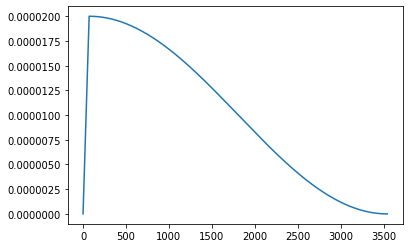

In [89]:
optimizer = transformers.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)

epochs = 5
num_training_steps = len(trn_dl) * epochs
num_warmup_steps = int(len(trn_dl) * 0.1)
scheduler = transformers.get_cosine_schedule_with_warmup(
                optimizer,
                num_warmup_steps,
                num_training_steps
            )

lrs = []
for epoch in range(epochs):
    for _ in trn_dl:
        lrs.append(scheduler.get_last_lr())
        optimizer.step()
        scheduler.step()
        
plt.plot(lrs)

Dataset written in another method. This will be much faster.

In [96]:
class BERTDataSetV2(Dataset):
    def __init__(self, df):
        self.encodeds = tokenizer.batch_encode_plus(
            df.excerpt,
            add_special_tokens=True,  # <s> and </s>
            max_length=322,          # default 512 for bert
            padding='max_length',    # padding  <pad>
            truncation=True,         # cut if length > max length
           
        )
        self.targets = df.target

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):

        ids = torch.tensor(self.encodeds['input_ids'][idx], dtype=torch.long)
        mask = torch.tensor(self.encodeds['attention_mask'][idx], dtype=torch.long)

        target = torch.tensor(self.targets[idx], dtype=torch.float)

        return {
            'ids': ids,
            'masks': mask,
            'targets': target
        }

In [97]:
import time

In [98]:
trn_ds = BERTDataSetV2(trn_df)
trn_dl = DataLoader(trn_ds,
                    batch_size=4,
                    shuffle=True,
                    num_workers=0,
                    pin_memory=True)



start = time.time()
for x in trn_dl:
    pass
m, s = divmod(time.time() - start, 60)
print(m, s)

0.0 0.2142484188079834


In [36]:
trn_ds = BERTDataSet(trn_df)
trn_dl = DataLoader(trn_ds,
                    batch_size=4,
                    shuffle=True,
                    num_workers=0,
                    pin_memory=True)



start = time.time()
for x in trn_dl:
    pass
m, s = divmod(time.time() - start, 60)
print(m, s)

0.0 2.8391008377075195
